# Model Application

**Author:** Florian Klaver  

In this Jupyter Notebook, the best performing models are applied to two full images to assess how well they performe in a larger environment, simulating a real life use.

---
## Setup

In [1]:
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
import joblib
from rasterio import features
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# Configurations

# Paths 
sentinel_dir = '../data/Sentinel_CH/'                                   # Sentinel-2 data directory
av_data_path = "../data/amtliche_vermessung_zh/DM01AVZH24LV95.gpkg"     # AV data path
fb_data_path = "../data/amtliche_vermessung_zh/Feuerwehr_-OGD.gpkg"     # Fire brigade data path
masks_dir = '../data/ground_truth_masks/'                               # Ground truth masks directory
output_dir = '../docs/images/'                                          # Output directory for images

os.makedirs(output_dir, exist_ok=True)

matches_df = pd.read_csv('../data/temporal_matches.csv') 
cloud_stats_df = pd.read_csv('../data/cloud_masking_stats.csv')

GRASSLAND_CLASS = 'humusiert.Acker_Wiese_Weide'
CLOUD_BAND = 13
CLOUD_THRESHOLD = 30

In [3]:
# Find the best "Positive Pair" (Mowing Pair) 

# Merge the two dataframes to get cloud info for each match
combined_stats = pd.merge(
    matches_df, 
    cloud_stats_df, 
    on='event_date_str', 
    how='left'
)

# Sort by 'pct_cloudy_pos' in ascending order (least cloudy first)
best_pairs = combined_stats.sort_values(by='pct_cloudy_pos', ascending=True)

# Display the Top 5 Best Pairs 
print("--- Top 5 Best Image Pairs (Least Cloudy) ---")
print(best_pairs[
    ['event_date_str', 'before_near_file', 'after_file', 'pct_cloudy_pos']
].head(5).to_string(index=False))

--- Top 5 Best Image Pairs (Least Cloudy) ---
 event_date_str before_near_file     after_file  pct_cloudy_pos
       20200811   2020-08-07.tif 2020-08-12.tif        0.142268
       20200810   2020-08-07.tif 2020-08-12.tif        0.142268
       20190702   2019-06-29.tif 2019-07-04.tif        0.144615
       20190703   2019-06-29.tif 2019-07-04.tif        0.144615
       20200805   2020-07-30.tif 2020-08-07.tif        0.771438


## Functions
All necessary steps are split up into function to keep the code easily reusable with different models.

In [4]:
#  Helper Functions for Vegetation Indices

def calculate_ndvi(nir, red):
    """Calculates NDVI, handle division by zero"""
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = (nir - red) / (nir + red)
    ndvi[np.isinf(ndvi)] = np.nan 
    return ndvi

def calculate_evi(nir, red, blue):
    """Enhanced Vegetation Index"""
    with np.errstate(divide='ignore', invalid='ignore'):
        evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))
    evi[np.isinf(evi)] = np.nan 
    return evi

def calculate_savi(nir, red, L=0.5):
    """Soil Adjusted Vegetation Index (L=0.5 is standard)"""
    with np.errstate(divide='ignore', invalid='ignore'):
        savi = ((nir - red) / (nir + red + L)) * (1 + L)
    savi[np.isinf(savi)] = np.nan
    return savi

def calculate_gndvi(nir, green):
    """Green Normalized Difference Vegetation Index"""
    with np.errstate(divide='ignore', invalid='ignore'):
        gndvi = (nir - green) / (nir + green)
    gndvi[np.isinf(gndvi)] = np.nan
    return gndvi

def calculate_ndii(nir, swir):
    """Normalized Difference Infrared Index (for water content)"""
    with np.errstate(divide='ignore', invalid='ignore'):
        ndii = (nir - swir) / (nir + swir)
    ndii[np.isinf(ndii)] = np.nan
    return ndii

In [5]:
# Scene Preparation Function
def prepare_scene_features(before_image_path, after_image_path, ground_cover_path, fire_brigade_path, features_to_keep):
    """
    Loads images, calculates ALL possible features, creates grassland mask, 
    and returns a DataFrame filtered to 'features_to_keep'.
    """
    print("\n--- Processing Scene ---")
    print(f"Before: {os.path.basename(before_image_path)}")
    print(f"After:  {os.path.basename(after_image_path)}")
    
    with rasterio.open(before_image_path) as src_before, \
         rasterio.open(after_image_path) as src_after:
        
        meta = src_before.meta.copy()
        height = meta['height']
        width = meta['width']
        transform = meta['transform']
        crs = meta['crs']
        
        # Read Bands (Using indices from feature engineering)
        # B2(1), B3(2), B4(3), B8(7), B11(10)
        blue_b = src_before.read(1).astype(float)
        green_b = src_before.read(2).astype(float)
        red_b = src_before.read(3).astype(float)
        nir_b = src_before.read(7).astype(float)
        swir_b = src_before.read(10).astype(float)
        cloud_prob_b = src_before.read(CLOUD_BAND).astype(float)
        
        blue_a = src_after.read(1).astype(float)
        green_a = src_after.read(2).astype(float)
        red_a = src_after.read(3).astype(float)
        nir_a = src_after.read(7).astype(float)
        swir_a = src_after.read(10).astype(float)
        cloud_prob_a = src_after.read(CLOUD_BAND).astype(float)

    # Calculate Indices (After & Before)
    ndvi_a = calculate_ndvi(nir_a, red_a)
    evi_a = calculate_evi(nir_a, red_a, blue_a)
    savi_a = calculate_savi(nir_a, red_a)
    ndii_a = calculate_ndii(nir_a, swir_a)
    gndvi_a = calculate_gndvi(nir_a, green_a)
    ndvi_b = calculate_ndvi(nir_b, red_b)
    evi_b = calculate_evi(nir_b, red_b, blue_b)
    savi_b = calculate_savi(nir_b, red_b)
    ndii_b = calculate_ndii(nir_b, swir_b)
    gndvi_b = calculate_gndvi(nir_b, green_b)

    # Dictionary of ALL 20 Potential Features
    all_features_dict = {
        'ndvi_after': ndvi_a, 'evi_after': evi_a, 'savi_after': savi_a, 'gndvi_after': gndvi_a, 'ndii_after': ndii_a,
        'ndvi_diff': ndvi_a - ndvi_b, 'evi_diff': evi_a - evi_b, 'savi_diff': savi_a - savi_b, 'gndvi_diff': gndvi_a - gndvi_b, 'ndii_diff': ndii_a - ndii_b,
        'blue_diff': blue_a - blue_b, 'green_diff': green_a - green_b, 'red_diff': red_a - red_b, 'nir_diff': nir_a - nir_b, 'swir_diff': swir_a - swir_b,
        'blue_after': blue_a, 'green_after': green_a, 'red_after': red_a, 'nir_after': nir_a, 'swir_after': swir_a
    }
    
    # Stack only the Requested Features
    try:
        feature_stack = np.stack([all_features_dict[name] for name in features_to_keep])
    except KeyError as e:
        print(f"ERROR: Model expects {e}, but it wasn't calculated.")
        print(f"Available: {list(all_features_dict.keys())}")
        raise e

    feature_df = pd.DataFrame(feature_stack.reshape(len(features_to_keep), -1).T, columns=features_to_keep)
    
    # Grassland mask
    av_data = gpd.read_file(ground_cover_path, layer="Bodenbedeckung_BoFlaeche_Area").to_crs(crs)
    grassland = av_data[av_data['Art_TXT'] == GRASSLAND_CLASS]

    if len(grassland) > 0:
        grassland_mask = features.rasterize(
            shapes=grassland.geometry, out_shape=(height, width), transform=transform,
            fill=0, default_value=1, dtype='uint8'
        ).astype(bool).flatten()
    else:
        grassland_mask = np.zeros(height * width, dtype=bool)

    # Airport area boundary mask
    fb_data = gpd.read_file(fire_brigade_path, layer="FW_GEMEINDEN_F").to_crs(crs)
    airport_poly = fb_data[fb_data['GEMEINDENAME'] == 'Flughafen Zürich']

    # CRS should already match, but just to be sure
    if airport_poly.crs != crs:
        airport_poly = airport_poly.to_crs(crs)

    if not airport_poly.empty:
        airport_mask = features.rasterize(
            shapes=airport_poly.geometry, 
            out_shape=(height, width), 
            transform=transform,
            fill=0, default_value=1, dtype='uint8'
        ).astype(bool).flatten()
    else:
        print("Warning: No airport polygon found in the data.")
        airport_mask = np.zeros(height * width, dtype=bool)

    # Cloud mask and NaN mask    
    cloud_mask = ((cloud_prob_b > CLOUD_THRESHOLD) | (cloud_prob_a > CLOUD_THRESHOLD)).flatten()
    nan_mask = feature_df.isna().any(axis=1)
    
    # Combine Masks for Valid Pixels
    valid_pixels_mask = grassland_mask & airport_mask & ~cloud_mask & ~nan_mask
    
    return feature_df, valid_pixels_mask, meta, height, width


In [6]:
# Prediction Function
def run_prediction(model, feature_df, valid_mask, height, width, output_path, meta):
    """Applies the model to valid pixels and saves the result."""
    print(f"Predicting on {valid_mask.sum()} valid pixels...")
    
    prediction_flat = np.full(height * width, -1, dtype=np.int8)
    valid_data = feature_df[valid_mask]
    
    if len(valid_data) > 0:
        preds = model.predict(valid_data)
        prediction_flat[valid_mask] = preds
    else:
        print("Warning: No valid pixels to predict.")
        
    prediction_map = prediction_flat.reshape(height, width)
    meta.update({'count': 1, 'dtype': 'int8', 'nodata': -1})
    
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(prediction_map, 1)
        
    print(f"Saved to {output_path}")
    return output_path

In [7]:
# Visualization Function
def evaluate_and_visualize(prediction_path, ground_truth_names, masks_dir, background_image_path):
    """
    1. Calculates quantitative metrics (Confusion Matrix, F1, etc.).
    2. Plots a Difference Map (TP, FP, FN) on top of the satellite image and Confusion Matrix side by side
    """
    try:
        base_name = os.path.basename(prediction_path).split('.')[0]
        
        # Load Prediction
        with rasterio.open(prediction_path) as src:
            pred_map = src.read(1)
            height, width = pred_map.shape
            valid_mask = pred_map != -1

        # Load and Combine Ground Truth 
        gt_combined = np.zeros((height, width), dtype=np.uint8)
        for name in ground_truth_names:
            path = os.path.join(masks_dir, name)
            if os.path.exists(path):
                with rasterio.open(path) as src:
                    gt_layer = src.read(1)
                    gt_combined = np.maximum(gt_combined, gt_layer)
        
        # Prepare Data for Metrics 
        y_pred = pred_map[valid_mask]
        y_true = gt_combined[valid_mask]
        
        if len(y_true) == 0:
            print("No valid pixels for evaluation.")
            return

        # Calculate Confusion Matrix
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        # Return Classification Report as dictionary
        report_dict = classification_report(
            y_true, y_pred, 
            target_names=['No Mowing', 'Mowing'], 
            output_dict=True
        )

        metrics = {
            'accuracy': report_dict['accuracy'],
            'precision_mowing': report_dict['Mowing']['precision'],
            'recall_mowing': report_dict['Mowing']['recall'],
            'f1_mowing': report_dict['Mowing']['f1-score'],
            'f1_macro': report_dict['macro avg']['f1-score']
        }
        
        # Print Text Report
        print(f"REPORT: {base_name}")
        print(classification_report(y_true, y_pred, target_names=['No Mowing', 'Mowing']))


        # PLOT 1: Prediction Map
        # Difference Map logic
        diff_map = np.zeros((height, width), dtype=float)
        diff_map[:] = np.nan 

        # TP (Green), FP (Red), FN (Blue)
        mask_tp = (pred_map == 1) & (gt_combined == 1)
        mask_fp = (pred_map == 1) & (gt_combined == 0)
        mask_fn = (pred_map == 0) & (gt_combined == 1)
        
        diff_map[mask_tp] = 1
        diff_map[mask_fp] = 2
        diff_map[mask_fn] = 3

        # Background Image
        with rasterio.open(background_image_path) as src:
            r = np.clip(src.read(3) / 2500, 0, 1) 
            g = np.clip(src.read(2) / 2500, 0, 1) 
            b = np.clip(src.read(1) / 2500, 0, 1) 
            rgb = np.dstack((r, g, b))

        fig_map, ax_map = plt.subplots(figsize=(12, 12)) 
        
        ax_map.imshow(rgb) 
        cmap = ListedColormap(['#00CCFF', '#FF9900', '#FF00FF']) 
        ax_map.imshow(diff_map, cmap=cmap, vmin=0.5, vmax=3.5, alpha=0.7)
        
        legend_patches = [
            mpatches.Patch(color='#00CCFF', label='True Positive'),
            mpatches.Patch(color='#FF9900', label='False Positive'),
            mpatches.Patch(color='#FF00FF', label='False Negative')
        ]
        ax_map.legend(handles=legend_patches, loc='upper right', framealpha=0.9, fontsize=10)
        #ax_map.set_title(f"Spatial Analysis: {base_name}", fontsize=16)
        ax_map.axis('off')

        map_save_path = os.path.join('../docs/images/', f"eval_map_{base_name}.png")
        plt.savefig(map_save_path, dpi=300, bbox_inches='tight')
        print(f"Map saved to: {map_save_path}")
        plt.show()

        # PLOT 2: Confusion Matrix

        fig_mat, ax_mat = plt.subplots(figsize=(5, 5))
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Mowed', 'Mowed'])
        
        disp.plot(ax=ax_mat, cmap='Blues', colorbar=False, values_format='d')
        #ax_mat.set_title("Confusion Matrix", fontsize=14)
        ax_mat.set_xlabel('Predicted Label', fontsize=13)
        ax_mat.set_ylabel('True Label', fontsize=13)
        ax_mat.tick_params(axis='both', which='major', labelsize=11)
        

        matrix_save_path = os.path.join('../docs/images/', f"eval_matrix_{base_name}.png")
        plt.savefig(matrix_save_path, dpi=300, bbox_inches='tight')
        print(f"Matrix saved to: {matrix_save_path}")
        plt.show()


        return metrics
        

    except Exception as e:
        print(f"Visualization Error: {e}")
        raise e

In [8]:
# Master Function
def run_full_assessment(model_path, model_features, before_img, after_img, gt_masks):
    """
    Function combining all other function for one simple call. 
    Given a model path and feature list, model is applied and evaluated on the whole scene.
    """
    if not os.path.exists(model_path):
        print(f"Skipping: {model_path} not found.")
        return

    print(f"\n{'='*60}")
    print(f"RUNNING ASSESSMENT FOR: {os.path.basename(model_path)}")
    print(f"{'='*60}")
    
    # Load Model
    model = joblib.load(model_path)
    
    # Prepare Data (Only calculates what this specific model needs!)
    feature_df, valid_mask, meta, h, w = prepare_scene_features(
        before_img, after_img, av_data_path, fb_data_path, model_features
    )
    
    
    img_base = os.path.basename(after_img).replace('.tif', '')
    model_base = os.path.basename(model_path).replace('.joblib', '')
    
    out_name = f'pred_map_{img_base}_{model_base}.tif'
    out_path = os.path.join(output_dir, out_name)

    # Run Prediction
    run_prediction(model, feature_df, valid_mask, h, w, out_path, meta)
    
    # Visualize and get metrics
    metrics = evaluate_and_visualize(out_path, gt_masks, masks_dir, after_img)

    if metrics:
        # Add model name to metrics
        metrics['model_name'] = model_base
        return metrics
    else:
        return None

---
## Application

In [9]:
# Define Scene
# Dates chosen from the least cloudy image pair check
scene_before = os.path.join(sentinel_dir, '2020-08-07.tif')
scene_after = os.path.join(sentinel_dir, '2020-08-12.tif')
scene_masks = ['mask_20200811.tif', 'mask_20200810.tif']

# Total number of mowed pixels in both gounnd truth masks (for comparison with confusion matrices)
total_mowed_pixels = 0
for mask_name in scene_masks:
    mask_path = os.path.join(masks_dir, mask_name)
    with rasterio.open(mask_path) as src:
        mask_data = src.read(1)
        total_mowed_pixels += np.sum(mask_data == 1)
print(f"Total Mowed Pixels in Ground Truth: {total_mowed_pixels}")


Total Mowed Pixels in Ground Truth: 2252


In [10]:
# Define Feature Sets
features_hybrid = [
    'ndii_diff',   # Moisture Change (Primary Signal)
    'ndii_after',  # Moisture State (Context)
    'gndvi_diff',  # Greenness Change (Validation)
    'swir_after'   # Structure/Brightness State (Absolute Reference)
]
features_ndii = ['ndii_diff']
features_ndvi = ['ndvi_diff']

# Initialize list to store metrics
results_list = []

### Single-Feature (NDII) Baseline Random Forest Model


RUNNING ASSESSMENT FOR: baseline_rf_ndii.joblib

--- Processing Scene ---
Before: 2020-08-07.tif
After:  2020-08-12.tif


c:\Users\flori\anaconda3\envs\PA2\Lib\site-packages\pyogrio\raw.py:200: RuntimeWarning: GPKG: bad application_id=0x00000000 on '../data/amtliche_vermessung_zh/DM01AVZH24LV95.gpkg'
  return ogr_read(


Predicting on 33768 valid pixels...
Saved to ../docs/images/pred_map_2020-08-12_baseline_rf_ndii.tif
REPORT: pred_map_2020-08-12_baseline_rf_ndii
              precision    recall  f1-score   support

   No Mowing       0.97      0.81      0.89     31521
      Mowing       0.20      0.65      0.31      2247

    accuracy                           0.80     33768
   macro avg       0.59      0.73      0.60     33768
weighted avg       0.92      0.80      0.85     33768

Map saved to: ../docs/images/eval_map_pred_map_2020-08-12_baseline_rf_ndii.png


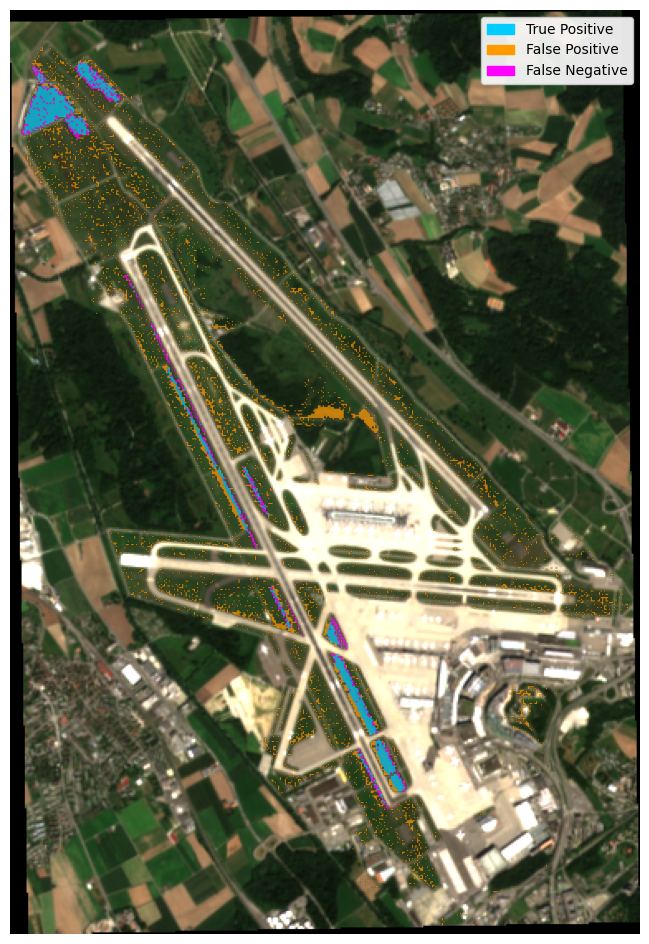

Matrix saved to: ../docs/images/eval_matrix_pred_map_2020-08-12_baseline_rf_ndii.png


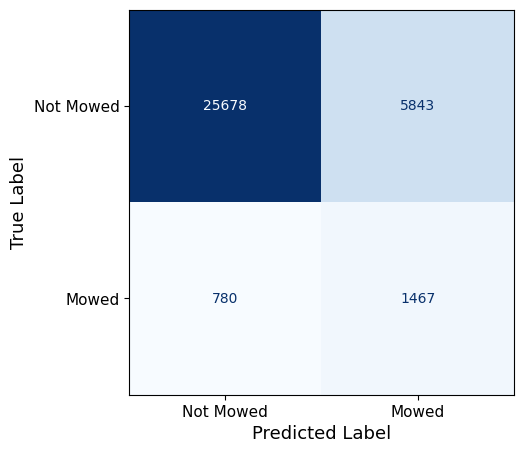

In [11]:
res1 = run_full_assessment(
    model_path= '../models/baseline_rf_ndii.joblib',
    model_features= features_ndii,
    before_img= scene_before,
    after_img= scene_after,
    gt_masks= scene_masks
)
results_list.append(res1)

### Single-Feature (NDII) Tuned SVM Model


RUNNING ASSESSMENT FOR: tuned_svm_ndii.joblib

--- Processing Scene ---
Before: 2020-08-07.tif
After:  2020-08-12.tif


c:\Users\flori\anaconda3\envs\PA2\Lib\site-packages\pyogrio\raw.py:200: RuntimeWarning: GPKG: bad application_id=0x00000000 on '../data/amtliche_vermessung_zh/DM01AVZH24LV95.gpkg'
  return ogr_read(


Predicting on 33768 valid pixels...
Saved to ../docs/images/pred_map_2020-08-12_tuned_svm_ndii.tif
REPORT: pred_map_2020-08-12_tuned_svm_ndii
              precision    recall  f1-score   support

   No Mowing       0.96      0.96      0.96     31521
      Mowing       0.42      0.39      0.41      2247

    accuracy                           0.92     33768
   macro avg       0.69      0.68      0.68     33768
weighted avg       0.92      0.92      0.92     33768

Map saved to: ../docs/images/eval_map_pred_map_2020-08-12_tuned_svm_ndii.png


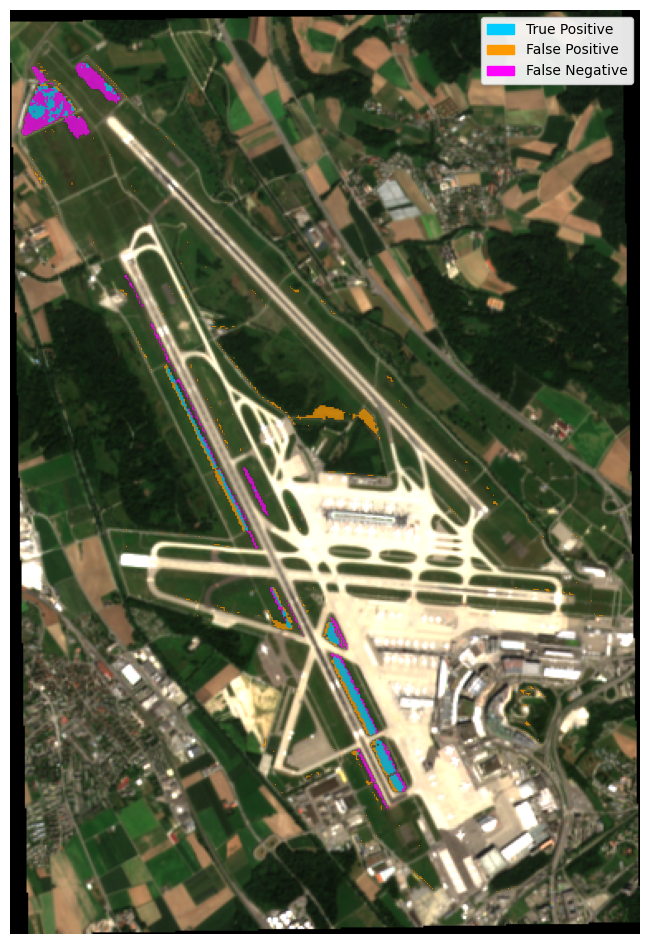

Matrix saved to: ../docs/images/eval_matrix_pred_map_2020-08-12_tuned_svm_ndii.png


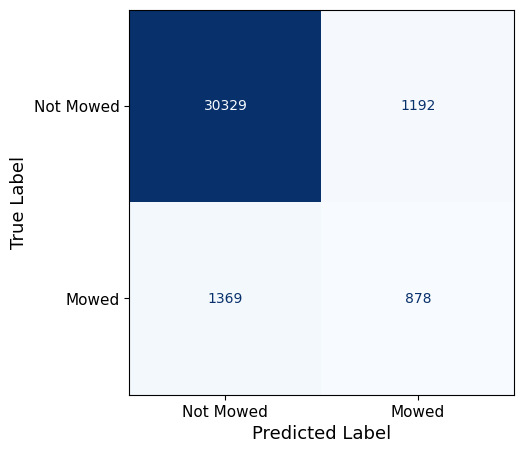

In [12]:
res2 = run_full_assessment(
    model_path='../models/tuned_svm_ndii.joblib',
    model_features=features_ndii, 
    before_img=scene_before, 
    after_img=scene_after, 
    gt_masks=scene_masks
)

results_list.append(res2)

### Hybrid-Feature Tuned LGBM Model


RUNNING ASSESSMENT FOR: tuned_lgbm_hybrid.joblib

--- Processing Scene ---
Before: 2020-08-07.tif
After:  2020-08-12.tif


c:\Users\flori\anaconda3\envs\PA2\Lib\site-packages\pyogrio\raw.py:200: RuntimeWarning: GPKG: bad application_id=0x00000000 on '../data/amtliche_vermessung_zh/DM01AVZH24LV95.gpkg'
  return ogr_read(


Predicting on 33768 valid pixels...
Saved to ../docs/images/pred_map_2020-08-12_tuned_lgbm_hybrid.tif
REPORT: pred_map_2020-08-12_tuned_lgbm_hybrid
              precision    recall  f1-score   support

   No Mowing       0.99      0.68      0.81     31521
      Mowing       0.17      0.88      0.28      2247

    accuracy                           0.70     33768
   macro avg       0.58      0.78      0.54     33768
weighted avg       0.93      0.70      0.77     33768

Map saved to: ../docs/images/eval_map_pred_map_2020-08-12_tuned_lgbm_hybrid.png


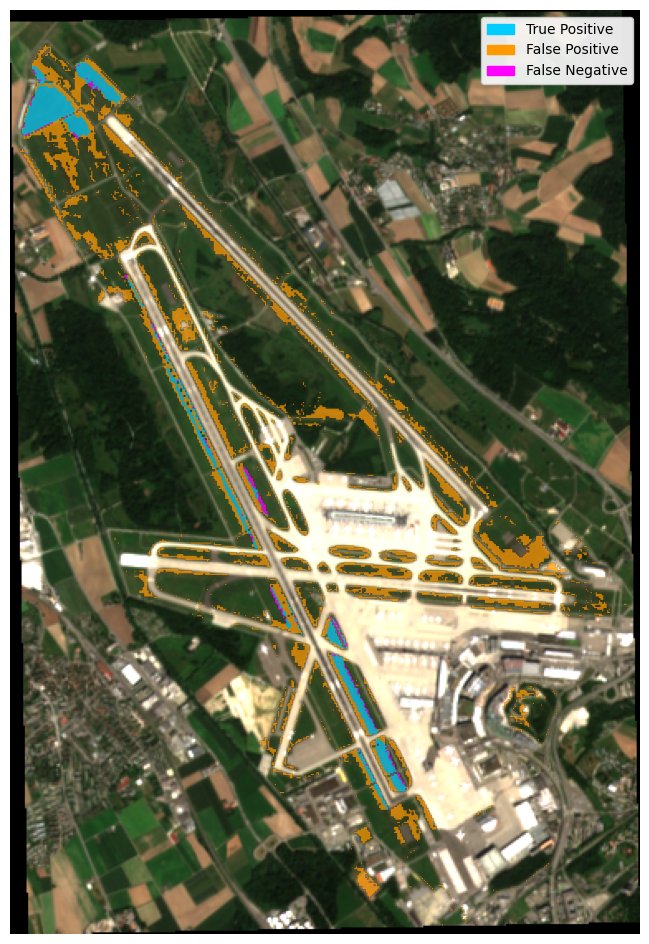

Matrix saved to: ../docs/images/eval_matrix_pred_map_2020-08-12_tuned_lgbm_hybrid.png


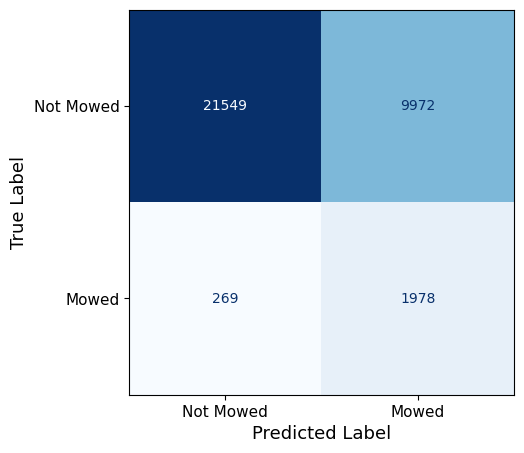

In [13]:
res3 = run_full_assessment(
    model_path='../models/tuned_lgbm_hybrid.joblib', 
    model_features=features_hybrid, 
    before_img=scene_before, 
    after_img=scene_after, 
    gt_masks=scene_masks
)

results_list.append(res3)

### Hybrid-Feature Tuned SVM Model


RUNNING ASSESSMENT FOR: tuned_svm_hybrid.joblib

--- Processing Scene ---
Before: 2020-08-07.tif
After:  2020-08-12.tif


c:\Users\flori\anaconda3\envs\PA2\Lib\site-packages\pyogrio\raw.py:200: RuntimeWarning: GPKG: bad application_id=0x00000000 on '../data/amtliche_vermessung_zh/DM01AVZH24LV95.gpkg'
  return ogr_read(


Predicting on 33768 valid pixels...
Saved to ../docs/images/pred_map_2020-08-12_tuned_svm_hybrid.tif
REPORT: pred_map_2020-08-12_tuned_svm_hybrid
              precision    recall  f1-score   support

   No Mowing       0.99      0.67      0.80     31521
      Mowing       0.16      0.90      0.27      2247

    accuracy                           0.68     33768
   macro avg       0.58      0.78      0.54     33768
weighted avg       0.93      0.68      0.76     33768

Map saved to: ../docs/images/eval_map_pred_map_2020-08-12_tuned_svm_hybrid.png


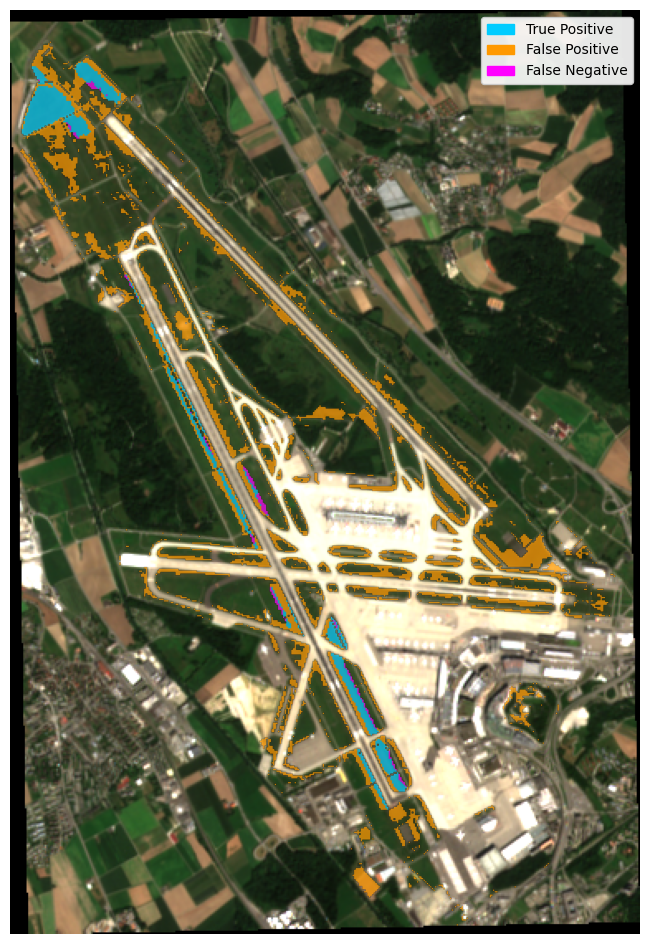

Matrix saved to: ../docs/images/eval_matrix_pred_map_2020-08-12_tuned_svm_hybrid.png


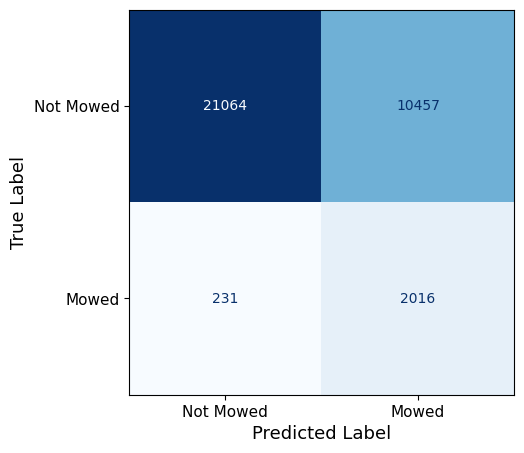

In [14]:
res4 = run_full_assessment(
    model_path='../models/tuned_svm_hybrid.joblib', 
    model_features=features_hybrid, 
    before_img=scene_before, 
    after_img=scene_after, 
    gt_masks=scene_masks
)

results_list.append(res4)

In [15]:
# Create Evaluation DataFrame from results list
evaluation_df = pd.DataFrame(results_list)

# Reorder columns for better readability
cols = ['model_name', 'accuracy', 'precision_mowing', 'recall_mowing', 'f1_mowing', 'f1_macro']
evaluation_df = evaluation_df[cols]

# Save evaluation results to CSV
evaluation_df.to_csv('../data/model_application_evaluation.csv', index=False)

display(evaluation_df)

model_name  accuracy  precision_mowing  recall_mowing  f1_mowing  \
0   baseline_rf_ndii  0.803868          0.200684       0.652870   0.307000   
1     tuned_svm_ndii  0.924159          0.424155       0.390743   0.406764   
2  tuned_lgbm_hybrid  0.696725          0.165523       0.880285   0.278650   
3   tuned_svm_hybrid  0.683487          0.161629       0.897196   0.273913   

   f1_macro  
0  0.596385  
1  0.683127  
2  0.543326  
3  0.535775

---
## Comparison of Differences

The Multi-Feature-Model seems to overpredict mowed pixels much more than the same model architecture using only ndii_diff as feature. This is very interesting, since it was visible in the ML_Model.ipynb notebook that they share very similar performance metrics. This observation can be partly explained by the higher sensitivity of the Multi-Feature-Model. In the ML_Model notebook it is visible in the confusion matrix that it catches more "weak" mows that the single-feature-model. But the price for this is more false positives.  
To explore this further, let's look at the differneces between the predictions more closely:

In [16]:
def compare_models_visually(pred_path_a, pred_path_b, background_image_path, model_a_name="Model A", model_b_name="Model B"):
    """
    Creates a Difference Map between two models.
    Cyan    = Both agree (Intersection)
    Orange  = Only Model A found it
    Magenta = Only Model B found it
    """
    print("\n--- Comparing Models ---")
    print(f"A: {model_a_name}")
    print(f"B: {model_b_name}")
    
    try:
        # Load Predictions
        with rasterio.open(pred_path_a) as src:
            map_a = src.read(1)
        with rasterio.open(pred_path_b) as src:
            map_b = src.read(1)
            
        # Load Background
        with rasterio.open(background_image_path) as src:
            r = np.clip(src.read(3) / 2500, 0, 1)
            g = np.clip(src.read(2) / 2500, 0, 1)
            b = np.clip(src.read(1) / 2500, 0, 1)
            rgb = np.dstack((r, g, b))

        # Create Difference Layers
        
        # Agreement (Both say Mowed) -> Cyan
        intersection = ((map_a == 1) & (map_b == 1)).astype(float)
        intersection[intersection == 0] = np.nan
        
        # Only A (A says Mowed, B says No/0) -> Orange
        only_a = ((map_a == 1) & (map_b != 1)).astype(float)
        only_a[only_a == 0] = np.nan
        
        # Only B (B says Mowed, A says No/0) -> Magenta
        only_b = ((map_b == 1) & (map_a != 1)).astype(float)
        only_b[only_b == 0] = np.nan

        # Plot
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(rgb)
        
        # Colors: Cyan (Agreement), Orange (Only A), Magenta (Only B)
        ax.imshow(intersection, cmap=ListedColormap(['#00CCFF']), alpha=0.8, interpolation='none') 
        ax.imshow(only_a, cmap=ListedColormap(['#FF9900']), alpha=0.8, interpolation='none')       
        ax.imshow(only_b, cmap=ListedColormap(['#FF00FF']), alpha=0.8, interpolation='none')       
        
        # Custom Legend
        legend_elements = [
            mpatches.Patch(facecolor='#00CCFF', label='Agreement (Both Models)'),
            mpatches.Patch(facecolor='#FF9900', label=f'Only {model_a_name}'),
            mpatches.Patch(facecolor='#FF00FF', label=f'Only {model_b_name}'),
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)
        # ax.set_title(f"Model Disagreement: {model_a_name} vs {model_b_name}", fontsize=16)
        ax.axis('off')
        
        # Save
        save_name = f'../docs/images/pred_comparison_{model_a_name.split()[0]}_vs_{model_b_name.split()[0]}.png'
        plt.savefig(save_name, dpi=300, bbox_inches='tight')
        print(f"Comparison saved to: {save_name}")
        plt.show()
        
    except Exception as e:
        print(f"Error comparing maps: {e}")


--- Comparing Models ---
A: Single Feature (NDII)
B: Hybrid Feature
Comparison saved to: ../docs/images/pred_comparison_Single_vs_Hybrid.png


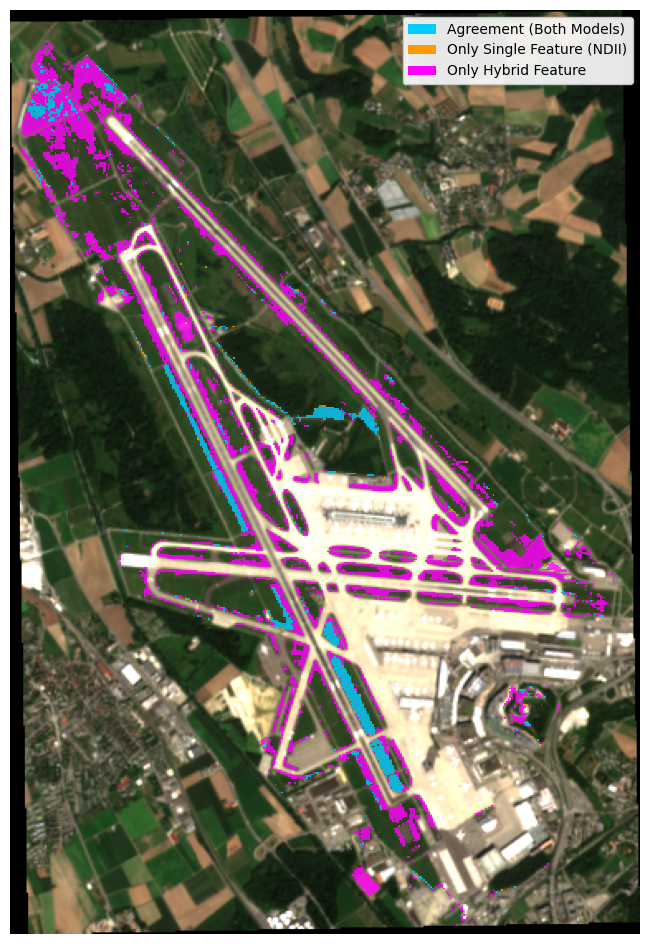

In [17]:
# Define paths for the two prediction maps to be compared
path_ndii = os.path.join(output_dir, 'pred_map_2020-08-12_tuned_svm_ndii.tif')
path_hybrid = os.path.join(output_dir, 'pred_map_2020-08-12_tuned_svm_hybrid.tif')

# Run Visual Comparison
compare_models_visually(
    pred_path_a=path_ndii, 
    pred_path_b=path_hybrid, 
    background_image_path=scene_after,
    model_a_name="Single Feature (NDII)",
    model_b_name="Hybrid Feature"
)

### Statistical Analysis
Here the disagreements between the single-feature and hybrid-feature models are further analysed and quantified.

In [18]:
# Load maps
with rasterio.open(path_ndii) as src:
    map_ndii = src.read(1)
    pixel_area = src.res[0] * src.res[1] 
    shape = map_ndii.shape

with rasterio.open(path_hybrid) as src:
    map_hybrid = src.read(1)

# Logic: 
# Agreement = (Single==1 & Hybrid==1)
# Hybrid_Only (Overprediction) = (Hybrid==1 & Single==0)
valid_comparison = (map_ndii != -1) & (map_hybrid != -1)
agreement = ((map_ndii == 1) & (map_hybrid == 1)) & valid_comparison
hybrid_excess = ((map_hybrid == 1) & (map_ndii == 0)) & valid_comparison

area_agreement = np.sum(agreement) * pixel_area
area_excess = np.sum(hybrid_excess) * pixel_area

print(f"Area Agreed (Both Mowed): {area_agreement:,.0f} m²")
print(f"Area Hybrid Only (Excess): {area_excess:,.0f} m²")
print(f"-> The Hybrid model predicts {area_excess/area_agreement*100:.1f}% MORE area than the Single model.")

Area Agreed (Both Mowed): 198,072 m²
Area Hybrid Only (Excess): 1,050,312 m²
-> The Hybrid model predicts 530.3% MORE area than the Single model.


**Spectal Feature investigation**

In [19]:
# Helper to load Ground Truth
def load_combined_gt(mask_files, shape):
    gt_combined = np.zeros(shape, dtype='uint8')
    for f in mask_files:
        path = os.path.join(masks_dir, f)
        if os.path.exists(path):
            with rasterio.open(path) as src:
                gt_combined = np.maximum(gt_combined, src.read(1))
    return gt_combined

In [20]:
# Define all features in the Hybrid set to inspect them all
features_to_analyze = ['ndii_diff', 'swir_after', 'gndvi_diff', 'ndii_after']


# Reuse data preparation function to get feature values for the scene
feature_df, valid_mask, meta, h, w = prepare_scene_features(
    scene_before, scene_after, av_data_path, fb_data_path, features_to_analyze
)

# Flatten 2D maps to match DataFrame
gt_mask_2d = load_combined_gt(scene_masks, (h, w))
gt_flat = gt_mask_2d.flatten()
hybrid_excess_flat = hybrid_excess.flatten()
map_hybrid_flat = map_hybrid.flatten()

# Filter to valid pixels only
feature_df_valid = feature_df[valid_mask].reset_index(drop=True)
gt_valid = gt_flat[valid_mask]
excess_valid = hybrid_excess_flat[valid_mask]
hybrid_pred_valid = map_hybrid_flat[valid_mask]

# Define Classes
# True Mowed: Ground Truth says 1
idx_true = np.where(gt_valid == 1)[0]

# Disputed (False Positives): Hybrid says 1, but Ground Truth says 0 (and Single said 0)
idx_disputed = np.where((excess_valid == 1) & (gt_valid == 0))[0]

# Not Mowed: True Grass (Ground Truth 0, Hybrid 0)
idx_not_mowed = np.where((gt_valid == 0) & (hybrid_pred_valid == 0))[0]


--- Processing Scene ---
Before: 2020-08-07.tif
After:  2020-08-12.tif


c:\Users\flori\anaconda3\envs\PA2\Lib\site-packages\pyogrio\raw.py:200: RuntimeWarning: GPKG: bad application_id=0x00000000 on '../data/amtliche_vermessung_zh/DM01AVZH24LV95.gpkg'
  return ogr_read(



--- Feature Statistics (Median values) ---
                        ndii_diff   swir_after  gndvi_diff  ndii_after
Class                                                                 
Hybrid False Positives  -0.005594  2659.044678    0.007596    0.005055
True Mowed              -0.067949  2734.062988   -0.028469    0.014745
True Not Mowed          -0.001475  2328.163574    0.009401    0.132439

------------------------------------------


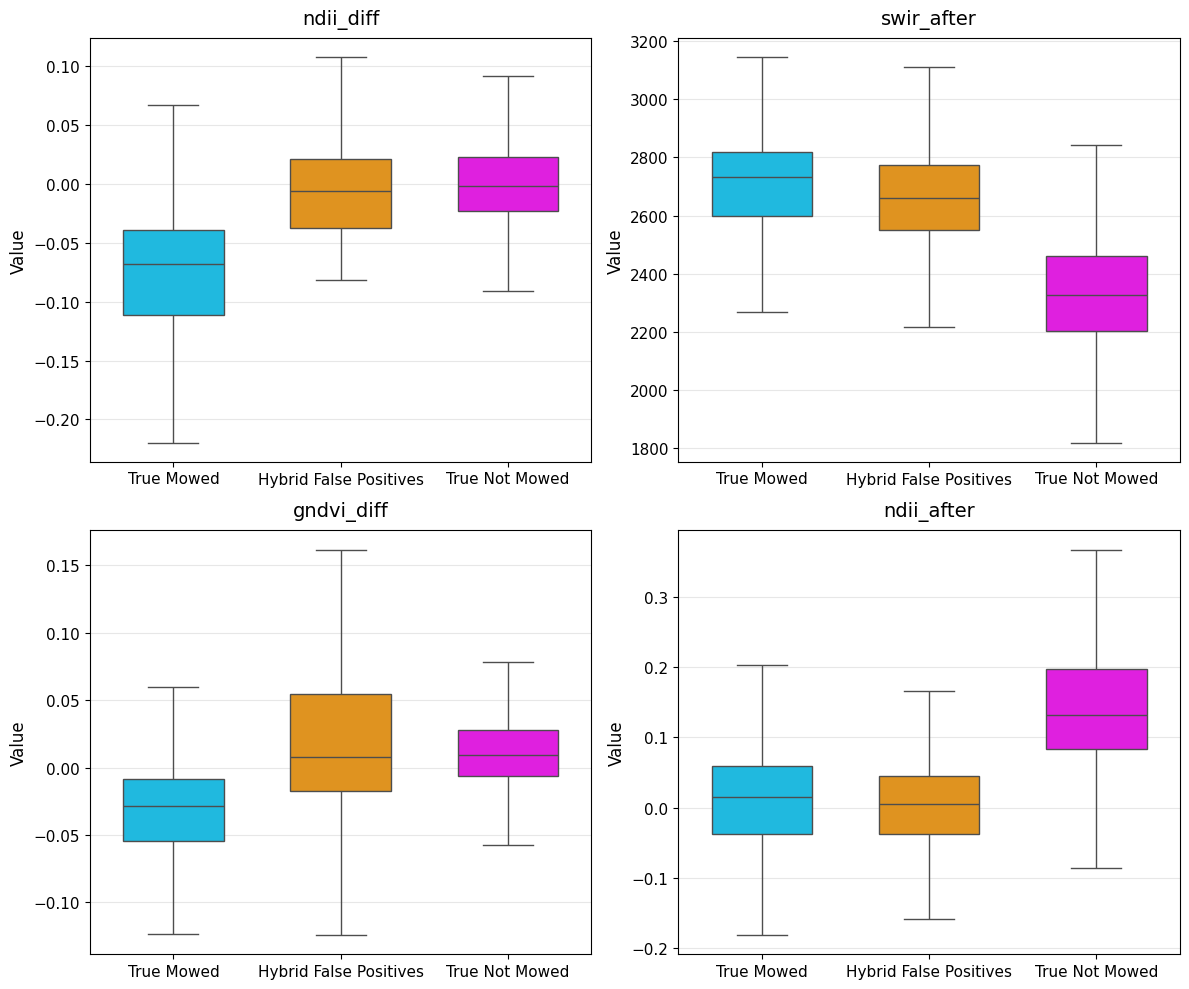

In [21]:
# Sample & Plot

n_samples = 5000
plot_data_list = []

for idx, label in [(idx_true, 'True Mowed'), (idx_disputed, 'Hybrid False Positives'), (idx_not_mowed, 'True Not Mowed')]:
    if len(idx) > 0:
        chosen = np.random.choice(idx, size=min(len(idx), n_samples), replace=False)
        df_subset = feature_df_valid.iloc[chosen].copy()
        df_subset['Class'] = label
        plot_data_list.append(df_subset)

if plot_data_list:
    plot_data = pd.concat(plot_data_list)
    
    # Print Statistics
    print("\n--- Feature Statistics (Median values) ---")
    stats = plot_data.groupby('Class')[features_to_analyze].median()
    print(stats)
    print("\n------------------------------------------")

    # Create 4 Subplots (One for each feature)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    custom_palette = {
        'True Mowed': '#00CCFF',            
        'Hybrid False Positives': '#FF9900', 
        'True Not Mowed': '#FF00FF'         
    }

    for i, feature in enumerate(features_to_analyze):
        sns.boxplot(x='Class', y=feature, hue='Class', data=plot_data, ax=axes[i], palette=custom_palette, showfliers=False, width=0.6, legend=False) # Hide outliers for cleaner view
        axes[i].set_title(f"{feature}", fontsize=14, pad=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Value", fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=11)
        axes[i].grid(True, alpha=0.3, axis= 'y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'overprediction_analysis_boxplot.png'), dpi=300)
    plt.show()
else:
    print("No valid data found for plotting.")